In this notebook we create a Q&A AI for sports questions

# Imports

In [ ]:
!pip install unidecode
!pip install sentence-transformers
!pip install datasets
!pip install nltk
!pip install transformers torch
!pip install evaluate

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import savetxt
import json
from json import JSONEncoder
import gzip
import ast
from sentence_transformers import SentenceTransformer, util
import time
import torch
from transformers import RobertaTokenizerFast, RobertaForQuestionAnswering
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
from transformers import Trainer, TrainingArguments, default_data_collator
from unidecode import unidecode
import string
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
import heapq
from collections import defaultdict
import pickle
import spacy
spacy_model = spacy.load('en_core_web_sm')
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, roc_curve, auc
from nltk.corpus import words, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')

from datasets import Dataset, load_dataset
import requests
import evaluate

from google.colab import drive
drive.mount('/content/drive')

# Data Gathering

## Wiki Data

### Wiki Web Scarping

In [ ]:
# Get title and return the wikipia page in the same name (if exists)
def wikipedia_page(title):
    params = {
        'action': 'query',            # extract data from wiki
        'format': 'json',             # file format set to json
        'titles': title,              # wiki page title
        'prop': 'extracts',           # asking for text
        'explaintext': True           # asking for simple text, not HTML format
    }

    # Contact wiki page
    response = requests.get(
         'https://en.wikipedia.org/w/api.php',
         params= params
     ).json()

    page = next(iter(response['query']['pages'].values()))
    # If page found, extract text and return it
    if 'extract' in page.keys():
        return page['extract']
    else:
        # If page not found
        return "Page not found"

In [ ]:
# Get list and length and keep only organs that shorter than the length
def remove_too_long(lst,long):
  new_list=[]
  for i in lst:
    if len(i) < long:
      new_list.append(i)
  return new_list

In [ ]:
# Get the main page from wikipedia
text = wikipedia_page("List of sports")
len(text)

17415

In [ ]:
# Divide our page into the titels
lines = text.split("\n")
print("the len of the original is",len(lines))

the len of the original is 1325


In [ ]:
# Remove the empty lines from the text
lines = [item for item in lines if item != ""]
print("the len after delete is",len(lines))

the len after delete is 1007


In [ ]:
# Delete the too long lines from the text (they  are not titles)
lines = remove_too_long(lines,40)
print("the len after delete is",len(lines))

the len after delete is 975


In [ ]:
# Return list of all the categories in the text
def give_titles(lst):
  result=[]
  for i in lst:
    if "==" in i:
      result.append(i)
  return result

In [ ]:
# Get titles
titles = give_titles(lines)

In [ ]:
# Remove all the appereance of the char in lst
def remove_char(char, lst):
  return [sentence.replace(char, "") for sentence in lst]

In [ ]:
# Remove " " and "="
titles = remove_char("=",titles)
titles = remove_char(" ",titles)

In [ ]:
# Get list of text and return list of lists that contain the groups
def divide_to_groups(lines):
  temp = []
  result = []

  for line in lines:
    if "==" in line: # If is title
      result.append(temp)
      temp=[]
    else:
      temp.append(line)
  result.append(temp)
  del result[0]
  return result

In [ ]:
# Create subjects list
subjects = divide_to_groups(lines)

In [ ]:
# Create list containing titles in odd spots and subjects in even spots
title_lst = []
sport_lst = []
for i in range(len(titles)):
  for j in range(len(subjects[i])):
    title_lst.append(titles[i])
    sport_lst.append(subjects[i][j])

In [ ]:
# Create the basic dataFrame (no pages at this point)
df = pd.DataFrame({'sport_type': title_lst, 'sport_name': sport_lst})

In [ ]:
# Delete all not titles (see also titles)
df = df.loc[df['sport_type'] != "Seealso"]

In [ ]:
# Extract all of the wiki pages
texts=[]
for page in df['sport_name']:
  texts.append(wikipedia_page(page))
df["original_text"] = texts

#### Dealing With Missing Data

In [ ]:
# Delete lines without text
df = df.loc[df["original_text"] != "Page not found"]

In [ ]:
# Delete fictional sports
df = df.loc[df["sport_type"] != "Fictionalsports"]

In [ ]:
# Find sports where the text wasn't found
missing_text = df.loc[df["original_text"]==""]

In [ ]:
# Find possibles corrections for words
def names_corrections(word):
    if not word.endswith("ing"):
        return [word]
    base = word[:-3]
    return [base,
            base+"e",
            base[:-1],
            base[:-1]+"ing"]

# Try a number of candidates for page name
def names_try_wikipeda(word):
  new_names = names_corrections(word)
  for name in new_names:
    text = wikipedia_page(name)
    if text != "Page not found":
      return text
  return "Page not found"

In [ ]:
# Second try to get texts
# List of sports with no text
missing_text_sports = list(missing_text["sport_name"])

try_change = []
for sport in missing_text_sports:
  try_change.append(names_try_wikipeda(sport))

missing_text["original_text"] = try_change

<ipython-input-67-cffc69afd0af>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_text["text"] = try_change


In [ ]:
# Restored texts
restored_texts = missing_text.loc[(missing_text["original_text"] != "") & (missing_text["original_text"] != "Page not found")]

In [ ]:
# Add restored texts
df = pd.concat([df, restored_texts], axis=0)
df = df_combined.drop_duplicates()
df.reset_index(drop=True, inplace=True)

#### Add More Data

In [ ]:
# Main Articles in wiki didnt show up, so we add them manually
main_articles = [("Air sports","Air sports"),("Athletics","Sport of athletics"),("Athletics","Track and field"),("Running","Running"),("Ball games","Volleyball"),("Ball games","Dodgeball"),("Ball games","Golf"),("Ball games","Goal (sports)"),
              ("Ball games","Football"),("Ball games","Paralympic football"),("Ball games","Beach soccer"),("Ball games","Street football(association football)"),("Ball games","Rugby league nines"),("Ball games","Handball"),("Ball games","Beach handball"),("Ball games","Roll ball"),("Ball games","Water polo"),("Ball games","Hockey"),
              ("Ball games","Goalball"),("Ball games","Ball hockey"),("Ball games","Field hockey"),("Ball games","Ice hockey"),("Ball games","Lacrosse"),("Ball games","Field lacrosse"),("Ball games","Polo"),("Ball games","Cycle polo"),("Ball games","Badminton"),("Ball games","Football tennis"),("Ball games","American handball"),("Ball games","Table tennis"),
              ("Ball games","Cue sports"),("Ball games","Ground billiards"),("Board sports","Boardsport"),("Board sports","Skateboarding"),("Boules sports","Boules"),("Bowling","Bowling"),("Climbing","Climbing"),("Climbing","Competition climbing"),("Climbing","Ice climbing"),("Grappling","Grappling"),("Grappling","Wrestling"),("Grappling","Sumo"),("Striking","Strike (attack)"),
              ("Striking","Boxing"),("Striking","Chess boxing"),("Striking","Karate"),("Striking","Taekwondo"),("Blood sport","Blood sport"),("Flying disc sports","Flying disc sports"),("Flying disc sports","Frisbee"),("Gymnastics","Gymnastics"),("Gymnastics","Calisthenics"),("Gymnastics","Toss juggling"),("Gymnastics","Parkour"),("Motorsports","Motorsport"),("Motorsports","Air racing"),("Motorsports","Auto racing"),("Pedal vehicle","Cycle sport"),("Pedal vehicle","Bicycle"),
              ("Pedal vehicle","BMX"),("Pedal vehicle","Unicycle"),("Racing","Marathon"),("Racing",("Sprint (running)")),("Snow sports","Skiing"),("Snow sports","Sledding"),("Shooting sports","Shooting sports"),("Shooting sports","Archery"),("Shooting sports","Airsoft"),("Strength sports","Arm wrestling"),("Walking","Hiking"),("Walking","Walking"),("Water sports","Boat racing"),("Water sports","Rafting"),("Water sports","Sailing"),("Water sports","Swimming (sport)"),("Water sports","Underwater sports"),("Water sports","Diving (sport)"),
              ("Weightlifting","Olympic weightlifting"),("Weightlifting","Powerlifting"),("Sports involving animals","Fishing"),("Sports involving animals","Hunting"),("Sports involving animals","Rodeo"),("Mind sports","Card game"),("Mind sports","Poker"),("Mind sports","Combination puzzle"),("Mind sports","Rubik's Cube"),("Mind sports","Esports"),("Mind sports","Board game"),("Table Sport","Air hockey"),("Team sport","Team sport"),("Paintball","Paintball"),("Wheelchair sports","Wheelchair basketball")]

In [ ]:
# Create new DF with Main Articles
sport_names=[]
sport_types=[]
for i in range(len(main_articls)):
  sport_types.append(main_articls[i][0])
  sport_names.append(main_articls[i][1])

df_main_articls = pd.DataFrame({
    'sport_type': sport_types,
    'sport_name': sport_names
})

texts=[]
for sport in sport_names:
  texts.append(wikipedia_page(i))
df_main_articls["original_text"] = texts

# Combine original DF and new DF
df = pd.concat([df,df_main_articls],axis=0)
df = df.drop_duplicates()
df.reset_index(drop=True, inplace=True)

### Preprocessing

In [ ]:
# Remove the end of the files that are harmful by the title of the part
# The title with 2 words
def remove_end_file_two_word(string,titles_to_delete):
  words=string.split()
  length=len(words)-1
  index=0

  while length > 1:
    # Look for the title
    if words[length] == titles_to_delete[-1] and words[length-1] == titles_to_delete[-2]:
      index=length-1
      break
    length -= 1
  # If title not found
  if index==0:
    return " ".join(words)

  # Delete all the words that part of the title
  length=len(words)-1
  while index < len(words):
    words.pop(index)

  return " ".join(words)

# The title with 1 word
def remove_end_file_one_word(string,titles_to_delete):
  words=string.split()
  length=len(words)-1
  index=0
  while length > 0:
    if words[length] == titles_to_delete[0]:
      index=length-1
      break
    length -= 1

  if index==0:
    return " ".join(words)

  length=len(words)-1
  while length > index:
    words.pop(length)
    length -= 1

  return " ".join(words)


In [ ]:
# Remove special characters
def remove_special_chars(text):
  return re.sub(r'[^\w\s]', '', text).replace('\n', '').replace("=",' ')

# Remove stopwords
def remove_stopwords(tokens):
  stop_words = stopwords.words("english")
  for word in stop_words:
    tokens = [value for value in tokens if value != word]
  return tokens

# Stemminze tokens and return it as text
def stem(tokens):
  ps = PorterStemmer()
  tokens = [ps.stem(word) for word in tokens]
  return " ".join(tokens)

# Lemmatize tokens and return it as text
def lemmatize(tokens):
  wnl = WordNetLemmatizer()
  tokens = [wnl.lemmatize(word) for word in tokens]
  return " ".join(tokens)

# Replace diacritics (è, é, ê, ë -> e)
def remove_diacritics(text):
  return unidecode(text)

# Remove the end of file
def remove_end_file(string):
  # Titles_to_delete=["see also","references","external links","sources"]
  string=remove_end_file_two_word(string,["See","also"])
  string=remove_end_file_one_word(string,["References"])
  string=remove_end_file_two_word(string,["External","links"])
  string=remove_end_file_one_word(string,["Sources"])
  return string

# Remove titles from text
def remove_titles(text):
    # Use a regex pattern to match anything between === and another === (inclusive)
    text=re.sub(r'===.*?===', '', text, flags=re.DOTALL)
    text=re.sub(r'==.*?==', '', text, flags=re.DOTALL)
    text=text.replace("=", "") # Remove after use
    return text

# Process only delete titles and external sources
def initial_process_text(text):
  text = remove_end_file(text)
  text = remove_titles(text)
  return text

# Process lower, remove unwanted chars and stopwords
def process_text(text):
  text = text.lower()
  text = remove_titles(text)
  text = remove_special_chars(text)
  text = remove_end_file(text)
  tokens = text.split()
  tokens = remove_stopwords(tokens)

  return " ".join(tokens)

# Process deals with diacritics
def full_process_text(text):
  text = text.lower()
  text = remove_titles(text)
  text = remove_diacritics(text)
  text = remove_special_chars(text)
  text = remove_end_file(text)
  tokens = text.split()
  tokens = remove_stopwords(tokens)
  return " ".join(tokens)


In [ ]:
df["processed_text"]=df["original_text"].apply(process_text)

In [ ]:
df["fully_processed_text"]=df["original_text"].apply(full_process_text)

In [ ]:
df["initial_processed_text"]=df["original_text"].apply(initial_process_text)

In [ ]:
stem_proc_lst=[]
for i in range(len(df)):
  tokens = df.iloc[i]["fully_processed_text"].split()
  stem_proc_lst.append(stem(tokens))
df["stem_text"]=stem_proc_lst

In [ ]:
lem_proc_lst=[]
for i in range(len(df)):
  tokens = df.iloc[i]["fully_processed_text"].split()
  lem_proc_lst.append(lemmatize(tokens))
df["lemmatized_text"]=lem_proc_lst

### Mini-LM embedding

In [ ]:
# Use miniLM for embedding
miniLM_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Return embedded sentences for a given doc
def embedding_doc(doc, model):
  sentences = sent_tokenize(doc)
  return model.encode(sentences), sentences

In [ ]:
# Embedded full texts
documents = list(df["initial_processed_text"])
docs_embeddings = [miniLM_model.encode(doc) for doc in documents]
df["embedded_miniLM_text"] = docs_embeddings

In [ ]:
# Sliding window over docs for chunks retrievel
def sliding_window_context(context, window_size=256, overlap=64):
    chunks = []
    words = context.split()
    i = 0
    while i < len(words):
        end = i + window_size
        if end >= len(words):
            chunk = " ".join(words[i:])
        else:
            chunk = " ".join(words[i:end])
        chunks.append(chunk)
        i = end - overlap  # Move i back by overlap to maintain context overlap
    return chunks

In [ ]:
# Get chunks and embedded chunks
chunks_list=[]
embedded_chunks_list=[]
for i in range(len(df)):
  chunks = sliding_window_context(df['initial_processed_text'][i])
  chunks_list.append(chunks)
  embedded_chunks_list.append([miniLM_model.encode(chunk) for chunk in chunks])

df["embedded_miniLM_chunks"] = embedded_chunks_list
df["chunks_list"] = chunks_list

In [ ]:
# Get sentences and embedded sentences
embedding_list=[]
sentences_list=[]
for i in range(len(df)):
  embedding, sentences = embedding_doc(df['initial_processed_text'][i],miniLM_model)
  embedding_list.append(embedding)
  sentences_list.append(sentences)

df["embedded_miniLM_sentences"] = embedding_list
df["sentences_list"] = sentences_list

In [ ]:
# Custom JSON Encoder for numpy arrays
class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

# Dictionary to hold the encoded data
numpyData = {}

# Iterate over the DataFrame rows
for i in range(len(df)):
    numpyData[i] = {
        "embedded_miniLM_text": json.dumps(df["embedded_miniLM_text"][i], cls=NumpyArrayEncoder),
        "embedded_miniLM_chunks": json.dumps(df["embedded_miniLM_chunks"][i], cls=NumpyArrayEncoder),
        "embedded_miniLM_sentences": json.dumps(df["embedded_miniLM_sentences"][i], cls=NumpyArrayEncoder),
    }

# Write all data into a single JSON file with gzip compression
with gzip.open('/content/drive/My Drive/'+folder1+'/'+folder2+'/'+"embedded_data.json.gz", "wt") as write_file:
    json.dump(numpyData, write_file, cls=NumpyArrayEncoder)

In [ ]:
folder1="Itamar&Yarden"
folder2="קבצי טקסט"
file="data_wikipedia.csv"
df.to_csv('/content/drive/My Drive/'+folder1+'/'+folder2+'/'+file, index=False)

### EDA

In [ ]:
df.head()

In [ ]:
df.describe()

In [ ]:
# Count how many words in data
sum_words = 0
for i in range(len(df)):
  sum_words += len(df.iloc[i]["original_text"].split())
sum_words

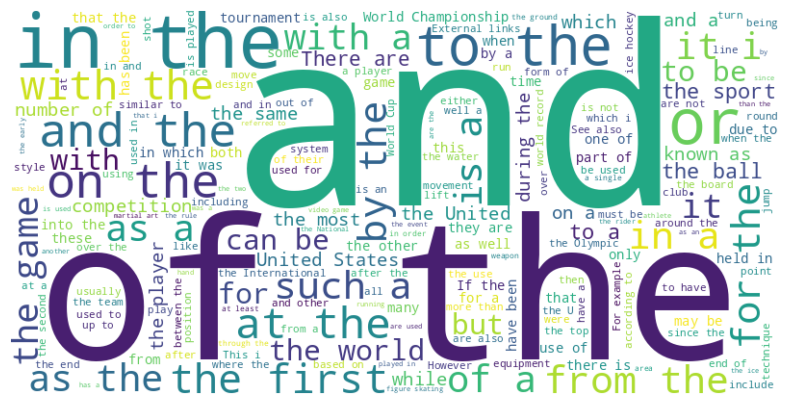

In [ ]:
# Create word-cloud on original text
wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=[]).generate(" ".join(df["original_text"]))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Create word-cloud on original text
wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=[]).generate(" ".join(df["fully_processed_text"]))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Questions Data

In [ ]:
qdf = pd.read_csv('/content/drive/My Drive/Itamar&Yarden/קבצי טקסט/questions.csv')

In [ ]:
# Clean DF
qdf = qdf.drop_duplicates()
qdf = qdf.dropna()

# Only relevent columns
qdf=qdf[['question1', 'question2']]

In [ ]:
# Process questions
def process_questions_text(text):
  text = text.lower()
  text = remove_diacritics(text)
  text = remove_special_chars(text)
  return text + "." # Add dot for separation

In [ ]:
qdf["question1"] = qdf["question1"].apply(process_questions_text)
qdf["question2"] = qdf["question2"].apply(process_questions_text)

In [ ]:
# Combine DF into one large text string
questions_text = ' '.join(qdf['question1'].astype(str)) + ' ' + ' '.join(qdf['question2'].astype(str))

In [ ]:
# Save into txt file
drive.mount('/content/drive')
with open('/content/drive/My Drive/Itamar&Yarden/קבצי טקסט/questions.txt', 'w') as f:
    f.write(questions_text)

## Open Web Text

In [ ]:
# Load the dataset in streaming mode
dataset = load_dataset("openwebtext", split="train", streaming=True)

# Create a subset by taking the first 10000 samples
subset = dataset.take(10000)

In [ ]:
samples_text = ""
# Iterate over the subset and process it
for sample in subset:
    samples_text = samples_text + " " + sample["text"]

In [ ]:
# Define the path in your Google Drive
file_path = '/content/drive/My Drive/Itamar&Yarden/קבצי טקסט/samples_text.txt'

# Write the text to the file
with open(file_path, 'w') as file:
    file.write(samples_text)

## SQuAD

In [ ]:
# Load the dataset (e.g., SQuAD for QA task)
dataset = load_dataset("squad")

# Shuffle the dataset to ensure a random distribution
dataset = dataset.shuffle(seed=42)

# Define split percentages
train_pct = 0.9
comparison_pct = 0.1

# Calculate split sizes
train_size = int(len(dataset['train']) * train_pct)
comparison_size = int(len(dataset['train']) * comparison_pct)

# Split the dataset
train_dataset = dataset['train'].select(range(train_size))
comparison_dataset = dataset['train'].select(range(train_size, train_size + comparison_size))
validation_dataset = dataset['validation']

In [ ]:
# Duplicate the data and change the questions and the answers (no answers)
def add_answerless_rows(df):

  df_no_answer = df.copy()
  df_no_answer["question"] = df_no_answer["question"].sample(frac=1).values
  df_no_answer["answers"] = df_no_answer["answers"].apply(lambda x: {'text': [''], 'answer_start': [-1]})

  # Combine DFs
  df = pd.concat([df,df_no_answer],ignore_index=True).sample(frac=1).reset_index(drop=True)
  return df

In [ ]:
comparison_dataset = add_answerless_rows(comparison_dataset)

# Spelling Error Correction

## Data Preprocessing

In [ ]:
# Turn series into text
textSport = ' '.join(df['initial_processed_text'].tolist())

In [ ]:
# Combine to one text
textSport = textSport + " " + samples_text + " " + questions_text

In [ ]:
# Data preprocess
def preprocess_text(text):
    # Remove 's from text
    text = re.sub(r'\'s', '', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Lower text
    text = text.lower()
    # Remove repeating letters
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    # Remove excess whitespace
    text = ' '.join(text.split())

    return text

# Build vocabulary from text
def build_vocab(text):
    words = word_tokenize(text)
    vocab = set(words)
    return vocab

# Count every words frequency
def build_unigram_counts(text):
    words = word_tokenize(text)
    unigram_counts = defaultdict(int)
    for word in words:
        unigram_counts[word] += 1
    return unigram_counts

# Count every 2 pair of words frequency
def build_bigram_counts(text):
    words = word_tokenize(text)
    bigram_counts = defaultdict(int)
    # Create bigram list
    bigrams = list(ngrams(words, 2))
    for bigram in bigrams:
        bigram_counts[bigram] += 1
    return bigram_counts

# Count every 3 pair of words frequency
def build_trigram_counts(text):
    words = word_tokenize(text)
    trigram_counts = defaultdict(int)
    # Create trigram list
    trigrams = list(ngrams(words, 3))
    for trigram in trigrams:
        trigram_counts[trigram] += 1
    return trigram_counts

In [ ]:
# Preprocess
processed_text = preprocess_text(textSport)

# Create vocabulary
vocab_sport = build_vocab(processed_text)
print("Vocabulary size:", len(vocab_sport))

# Culculates unigram and bigram frequencies
unigram_counts = build_unigram_counts(processed_text)
bigram_counts = build_bigram_counts(processed_text)
trigram_counts = build_trigram_counts(processed_text)

Vocabulary size: 289558


In [ ]:
# Combine them into one dictionary
ngram_counts = {
    "unigram": unigram_counts,
    "bigram": bigram_counts,
    "trigram": trigram_counts,
    "vocab": vocab_sport
}

# Save the combined object to a file
file_name = "ngram_counts.pkl"
with open('/content/drive/My Drive/'+folder1+'/'+folder2+'/'+file_name, 'wb') as file:
    pickle.dump(ngram_counts, file)

## Finding and correcting misspelled words

In [ ]:
# Alaph bet for candidates finding
abc = "abcdefghijklmnopqrstuvwxyz"

# Replace each letter with each letter in the ABC
def replaceLetters(word):
  candidates = []
  for i in range(len(word)):
    for letter in abc:
      alt = word[:i] + letter + word[i+1:]
      candidates.append(alt)
  return candidates

# Incert each letter in the ABC
def incertLetters(word):
  candidates = []
  for i in range(len(word)+1):
    for letter in abc:
      alt = word[:i] + letter + word[i:]
      candidates.append(alt)
  return candidates

# Delete each letter one at a time
def deleteLetters(word):
  candidates = []
  for i in range(len(word)):
    alt = word[:i] + word[i+1:]
    candidates.append(alt)
  return candidates

# Replace all letters with each others
def shuffleLetters(word):
  candidates = []
  for i in range(len(word)):
    for j in range(len(word)):
      # Convert the word to a list of characters
      alt = list(word)
      # Swap the letters at the specified indices
      alt[i], alt[j] = alt[j], alt[i]
      # Join the list back into a string
      alt = ''.join(alt)
      candidates.append(alt)
  return candidates

In [ ]:
# Generate possibles corrections for wrong spelled word
def generate_candidates(word, vocab, distance):
    if word in vocab:
        return {word}

    candidates = set(replaceLetters(word) + incertLetters(word) + deleteLetters(word) + shuffleLetters(word))
    if distance == 1:
        return candidates & vocab  # Return only known words

    # For distance=2, limit the generation
    second_round = set()
    for candidate in candidates:
        second_round.update(replaceLetters(candidate) + incertLetters(candidate) + deleteLetters(candidate) + shuffleLetters(candidate))
    return second_round & vocab


In [ ]:
def evaluate_sentence(sentence, trigram_counts, bigram_counts, unigram_counts, trigram_weight=0.7, bigram_weight=0.4, unigram_weight=0.3):
    score = 0
    total_unigram_count = sum(unigram_counts.values())

    # Calculate scores for trigrams, bigrams, and unigrams
    for i in range(len(sentence) - 2):  # Loop over the sentence, stopping 2 words before the end
        trigram = (sentence[i], sentence[i+1], sentence[i+2])
        bigram = (sentence[i], sentence[i+1])
        unigram = sentence[i]

        # Get the trigram, bigram, and unigram counts
        trigram_score = trigram_counts.get(trigram, 0)
        bigram_score = bigram_counts.get(bigram, 0)
        unigram_score = unigram_counts.get(unigram, 0)

        # Normalize the unigram score
        normalized_unigram_score = unigram_score / total_unigram_count if total_unigram_count > 0 else 0

        # Calculate the weighted score
        score += (trigram_weight * trigram_score) + (bigram_weight * bigram_score) + (unigram_weight * normalized_unigram_score)

    # Handle the last bigram and unigram for the final two words
    if len(sentence) >= 2:
        bigram = (sentence[-2], sentence[-1])
        bigram_score = bigram_counts.get(bigram, 0)
        unigram_score = unigram_counts.get(sentence[-2], 0)

        normalized_unigram_score = unigram_score / total_unigram_count if total_unigram_count > 0 else 0
        score += (bigram_weight * bigram_score) + (unigram_weight * normalized_unigram_score)

    # Add the last word's unigram score
    last_unigram_score = unigram_counts.get(sentence[-1], 0)
    normalized_last_unigram_score = last_unigram_score / total_unigram_count if total_unigram_count > 0 else 0
    score += (unigram_weight * normalized_last_unigram_score)

    return score


In [ ]:
# Find best sequence using beam search
def correct_spelling_error(words, vocab, beam_width, trigram_counts, bigram_counts, unigram_counts):
    # Detect named entities using spaCy on the original text (before preprocessing)
    doc = spacy_model(words)
    named_entities = [ent.text.lower() for ent in doc.ents]

    # Preproces the sentence
    words = preprocess_text(words).split(" ")
    # Start with correct words
    current_sequences = [(0, [])]  # sequence list, (score, sentence)

    for word in words:
        new_candidates = []

        # If the word was a named entity in the original text, skip correction
        if word in named_entities:
            candidates = [word]  # Keep the named entity unchanged
        else:
            # Generate candidates for the current word
            candidates = generate_candidates(word, vocab, 1)
            if not candidates:
                candidates = generate_candidates(word, vocab, 2)
                if not candidates:
                    candidates = [word]

        # Expand every possible sequence
        for score, seq in current_sequences:
            for candidate in candidates:
                new_seq = seq + [candidate]
                new_score = evaluate_sentence(new_seq, trigram_counts, bigram_counts, unigram_counts)
                new_candidates.append((new_score, new_seq))

        # Save only the sequences with the highest scores
        # beam_width - number of sequences that gets saved every time
        current_sequences = heapq.nlargest(beam_width, new_candidates, key=lambda x: x[0])
        print(current_sequences)
    # Return the best sequence
    best_sequence = max(current_sequences, key=lambda x: x[0])
    return best_sequence


# Answer Retrievel

## TF-IDF

In [ ]:
# Remove special characters
def remove_special_chars(text):
  return re.sub(r'[^\w\s]', '', text).replace('\n', '').replace("=",' ')

# Remove stopwords
def remove_stopwords(tokens):
  stop_words = stopwords.words("english")
  for word in stop_words:
    tokens = [value for value in tokens if value != word]
  return tokens

# Lemmatize tokens and return it as text
def lemmatize(tokens):
  wnl = WordNetLemmatizer()
  tokens = [wnl.lemmatize(word) for word in tokens]
  return "".join(tokens)

# Replace diacritics (è, é, ê, ë -> e)
def remove_diacritics(text):
  return unidecode(text)

def tf_idf_process_query(query):
  query = query.lower()
  query = remove_diacritics(query)
  query = remove_special_chars(query)
  tokens = query.split()
  tokens = remove_stopwords(tokens)
  processed_query = lemmatize(tokens)
  return processed_query

In [ ]:
# Create vocabelry and TF-IDF matrix from the docs
def create_tf_idf_array(docs):
  vectorizer = TfidfVectorizer(min_df=3)
  tfidf_matrix = vectorizer.fit_transform(docs)
  tfidf_array = tfidf_matrix.toarray()
  voc = vectorizer.get_feature_names_out()
  return tfidf_array, voc


In [ ]:
# Calculate the score of doc
def tf_idf_calc_score(doc, tokens, tf_idf_array, i, voc):
  score = 0
  for word in tokens:
    if word not in voc:
      continue
    if word in doc:
      score += tf_idf_array[i][voc.index(word)]

  return score

In [ ]:
# Find best doc from TF-IDF matrix
def tf_idf_find_docs(docs, query, tf_idf_array, voc, k=1):
  scores = []
  query_tokens=query.split()

  for i, doc in enumerate(docs):
    score = tf_idf_calc_score(doc, query_tokens, tf_idf_array, i, voc)
    score_doc = (score, doc)
    scores.append(score_doc)

  best_scores = sorted(scores,key=lambda x:x[0],reverse=True)
  k_best_score = best_scores[:k]

  return k_best_score

In [ ]:
# Get the 3 best docs for the query
def tf_idf_best_doc(query):
  processed_query = tf_idf_process_query(query)
  docs = list(df["lemmatized_text"])
  tf_idf_array, voc = create_tf_idf_array(docs)
  return tf_idf_find_docs(docs, processed_query, tf_idf_array, list(voc), 3)

## RoBERTa

### Model Building

In [ ]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained RoBERTa model and tokenizer
model_name = "roberta-base"  # You can also use "roberta-large"
tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
model = RobertaForQuestionAnswering.from_pretrained(model_name).to(device)  # Move model to GPU

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the inputs
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    contexts = [c.strip() for c in examples["context"]]

    # Include return_offsets_mapping=True to get the offset_mapping
    inputs = tokenizer(questions, contexts, max_length=128, truncation="only_second", padding="max_length", return_offsets_mapping=True)

    start_positions = []
    end_positions = []

    # Loop through tokenized inputs to compute start and end positions
    for i, offset in enumerate(inputs["offset_mapping"]):
        answer = examples["answers"][i]["text"][0]
        start_char = examples["answers"][i]["answer_start"][0]
        end_char = start_char + len(answer)

        # Find the start and end positions within the tokenized input
        sequence_ids = inputs.sequence_ids(i)
        context_start = sequence_ids.index(1)
        context_end = len(sequence_ids) - 1 - sequence_ids[::-1].index(1)

        start_position = end_position = 0
        for idx, (start, end) in enumerate(offset):
            if start <= start_char < end:
                start_position = idx
            if start < end_char <= end:
                end_position = idx
                break

        start_positions.append(start_position)
        end_positions.append(end_position)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs


Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

### Finding Best Hyperparameters

In [ ]:
# Reduce the training dataset to 10% of the original size
train_dataset = train_dataset.shuffle(seed=42).select(range(int(len(train_dataset) * 0.05)))
validation_dataset = validation_dataset.shuffle(seed=42).select(range(int(len(validation_dataset) * 0.05)))

In [ ]:
# Apply the preprocess_function to the dataset
tokenized_train_data = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
tokenized_validation_data = validation_dataset.map(preprocess_function, batched=True, remove_columns=validation_dataset.column_names)

Map:   0%|          | 0/3941 [00:00<?, ? examples/s]

#### Testing Batch Sizes

In [ ]:
results = []
batches = [8,16,32,64]

for batch_size in batches:
  # Set training arguments
  training_args = TrainingArguments(
      output_dir="./results",
      eval_strategy="epoch",
      logging_strategy="epoch",  # Logs at the end of each epoch
      learning_rate=2e-5,
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      num_train_epochs=4,
      weight_decay=0.01,
      report_to="none",
  )

  # Load the pre-trained RoBERTa model and tokenizer
  model_name = "roberta-base"  # You can also use "roberta-large"
  tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
  model = RobertaForQuestionAnswering.from_pretrained(model_name).to(device)  # Move model to GPU

  # Initialize Trainer
  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train_data,
      eval_dataset=tokenized_validation_data,
      tokenizer=tokenizer,
      data_collator=default_data_collator
  )

  # Train the model
  trainer.train()

  # Evaluate the model
  eval_results = trainer.evaluate()

  # Add evaluation results with batch size to results list
  eval_results["batch_size"] = batch_size
  results.append(eval_results)

# Save all results to CSV
df = pd.DataFrame(results)

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\itama\AppData\Local\Temp\ipykernel_22616\3604466964.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.419200,1.592356
2,1.370800,1.443877
3,0.966700,1.549258
4,0.755000,1.553453


Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\itama\AppData\Local\Temp\ipykernel_22616\3604466964.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.663800,1.648668
2,1.510000,1.459249
3,1.131100,1.482214
4,0.952500,1.518535


Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\itama\AppData\Local\Temp\ipykernel_22616\3604466964.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,3.038700,1.846918
2,1.725400,1.529513
3,1.363900,1.518432
4,1.202000,1.480897


Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\itama\AppData\Local\Temp\ipykernel_22616\3604466964.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,3.568500,2.260418
2,2.071000,1.748519
3,1.657400,1.590883
4,1.473100,1.562928


#### Testing Learning Rates

In [ ]:
results = []
#learning_rates = [3e-4, 1e-4, 5e-5, 3e-5, 2e-5]
learning_rates = [1e-5, 5e-6, 3e-6, 1e-6, 5e-7]

for lr in learning_rates:
  # Set training arguments
  training_args = TrainingArguments(
      output_dir="./results",
      eval_strategy="epoch",
      logging_strategy="epoch",  # Logs at the end of each epoch
      learning_rate=lr,
      per_device_train_batch_size=8,
      per_device_eval_batch_size=8,
      num_train_epochs=16,
      weight_decay=0.01,
      report_to="none",
  )

  # Load the pre-trained RoBERTa model and tokenizer
  model_name = "roberta-base"  # You can also use "roberta-large"
  tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
  model = RobertaForQuestionAnswering.from_pretrained(model_name).to(device)  # Move model to GPU

  # Initialize Trainer
  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train_data,
      eval_dataset=tokenized_validation_data,
      tokenizer=tokenizer,
      data_collator=default_data_collator
  )

  # Train the model
  trainer.train()

  # Evaluate the model
  eval_results = trainer.evaluate()

  # Add evaluation results with learning rate to results list
  eval_results["learning_rate"] = lr
  results.append(eval_results)

# Save all results to CSV
df_lr = pd.DataFrame(results)

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\itama\AppData\Local\Temp\ipykernel_35428\4292291089.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.640000,1.713740
2,1.571500,1.473481
3,1.207900,1.444690
4,0.936700,1.541754
5,0.757100,1.722897
6,0.611600,1.796070
7,0.498400,1.869048
8,0.420700,1.964611
9,0.355800,2.085435
10,0.308000,2.245294


Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\itama\AppData\Local\Temp\ipykernel_35428\4292291089.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,3.161500,1.954991
2,1.916100,1.652431
3,1.557700,1.573736
4,1.336600,1.510206
5,1.183600,1.586888
6,1.042400,1.564171
7,0.933100,1.628091
8,0.853400,1.599863
9,0.786900,1.642444
10,0.718600,1.697127


Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\itama\AppData\Local\Temp\ipykernel_35428\4292291089.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,3.627000,2.421908
2,2.250300,1.893004
3,1.844700,1.739214
4,1.626500,1.647288
5,1.476700,1.628941
6,1.361300,1.585970
7,1.264700,1.586451
8,1.175400,1.541136
9,1.121900,1.561605
10,1.066800,1.572866


Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\itama\AppData\Local\Temp\ipykernel_35428\4292291089.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,4.462800,3.862408
2,3.419900,2.883115
3,2.842400,2.495553
4,2.456600,2.188798
5,2.210100,2.057454
6,2.062400,1.966822
7,1.971200,1.926562
8,1.894800,1.862131
9,1.826500,1.827028
10,1.775600,1.807655


Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\itama\AppData\Local\Temp\ipykernel_35428\4292291089.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,4.712200,4.417273
2,4.216400,3.876984
3,3.649000,3.239571
4,3.254600,2.950964
5,3.011800,2.744747
6,2.804900,2.573191
7,2.663100,2.455433
8,2.513700,2.312817
9,2.391900,2.233085
10,2.308500,2.178524


#### Testing Weight Decays

In [ ]:
results = []
weight_decays = [0.001, 0.01, 0.05, 0.1]

for weight in weight_decays:
  # Set training arguments
  training_args = TrainingArguments(
      output_dir="./results",
      eval_strategy="epoch",
      logging_strategy="epoch",  # Logs at the end of each epoch
      learning_rate=2e-5,
      per_device_train_batch_size=8,
      per_device_eval_batch_size=8,
      num_train_epochs=4,
      weight_decay=weight,
      report_to="none",
  )

  # Load the pre-trained RoBERTa model and tokenizer
  model_name = "roberta-base"  # You can also use "roberta-large"
  tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
  model = RobertaForQuestionAnswering.from_pretrained(model_name).to(device)  # Move model to GPU

  # Initialize Trainer
  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=tokenized_train_data,
      eval_dataset=tokenized_validation_data,
      tokenizer=tokenizer,
      data_collator=default_data_collator
  )

  # Train the model
  trainer.train()

  # Evaluate the model
  eval_results = trainer.evaluate()

  # Add evaluation results with weight deacy to results list
  eval_results["weight_decay"] = weight
  results.append(eval_results)

# Save all results to CSV
df_weight = pd.DataFrame(results)

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\itama\AppData\Local\Temp\ipykernel_35428\648402470.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.379500,1.544812
2,1.391400,1.431676
3,0.989300,1.505299
4,0.762400,1.514862


Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\itama\AppData\Local\Temp\ipykernel_35428\648402470.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.386400,1.579632
2,1.357000,1.411588
3,0.969000,1.495125
4,0.738800,1.531484


Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\itama\AppData\Local\Temp\ipykernel_35428\648402470.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.378400,1.592324
2,1.353100,1.428435
3,0.963000,1.478950
4,0.721300,1.554780


Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\itama\AppData\Local\Temp\ipykernel_35428\648402470.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,2.381400,1.548139
2,1.366800,1.437580
3,0.974100,1.504637
4,0.743500,1.545683


#### Finale Model

In [ ]:
# Apply the preprocess_function to the full dataset
tokenized_train_data = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
tokenized_validation_data = validation_dataset.map(preprocess_function, batched=True, remove_columns=validation_dataset.column_names)

In [ ]:
# Full model training using best hyperparameters
# Set training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",  # Logs at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    report_to="none"
)

os.environ["WANDB_DISABLED"] = "true"

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_data,
    eval_dataset=tokenized_validation_data,
    tokenizer=tokenizer,
    data_collator=default_data_collator
)

# Train the model
trainer.train()

# Save the model
model.save_pretrained("./fine_tuned_roberta_qa")
tokenizer.save_pretrained("./fine_tuned_roberta_qa")


C:\Users\itama\AppData\Local\Temp\ipykernel_35428\1137399547.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.298500,1.011710
2,0.854900,0.962260


('./fine_tuned_roberta_qa\\tokenizer_config.json',
 './fine_tuned_roberta_qa\\special_tokens_map.json',
 './fine_tuned_roberta_qa\\vocab.json',
 './fine_tuned_roberta_qa\\merges.txt',
 './fine_tuned_roberta_qa\\added_tokens.json',
 './fine_tuned_roberta_qa\\tokenizer.json')

## MiniLM

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
# Evaluate all the sentences and return their scores
def evaluate_sentences(sentences, model, query):
  result=[]

  sentence_embeddings = model.encode(sentences)
  query_embedding = model.encode(query)

  for i in range(len(sentences)):
    score_par = util.cos_sim(query_embedding, sentence_embeddings[i])[0].item()
    result.append((sentences[i],score_par,i))

  return result

## Threshold Finding

### Success & Failure Scores

In [ ]:
# Get doc and query and return the answer
def get_answer(doc,query,model):
  sentences = sent_tokenize(doc)
  scores = evaluate_sentences(sentences, model, query)
  best_score = max(scores, key=lambda x: x[1])

  return best_score

In [ ]:
# Calculate scores for success and failure cases and return them as lists
def get_success_failure_scores(model, dataset):

  # Calculate the elapsed time
  start_t = time.time()

  success = []
  failure = []
  for row in dataset:
    context = row["context"]
    question = row["question"]
    answer = row["answers"]["text"][0]
    answer_start = row["answers"]["answer_start"]

    guess, score, i = get_answer(context,question,model)

    score = abs(score) # Handle negative vector distance

    # Divide into failure scenario and success scenario
    # tn
    if answer == "":
      failure.append(score)
    else:
      # tp
      if answer in guess:
        success.append(score)
      # fp
      else:
        failure.append(score)


  end_t = time.time()

  elapsed_t = end_t - start_t
  print(f"Elapsed time: {elapsed_t} seconds")

  return success, failure

In [ ]:
success, failure = get_success_failure_scores(model, dataset)

Elapsed time: 297.2481381893158 seconds


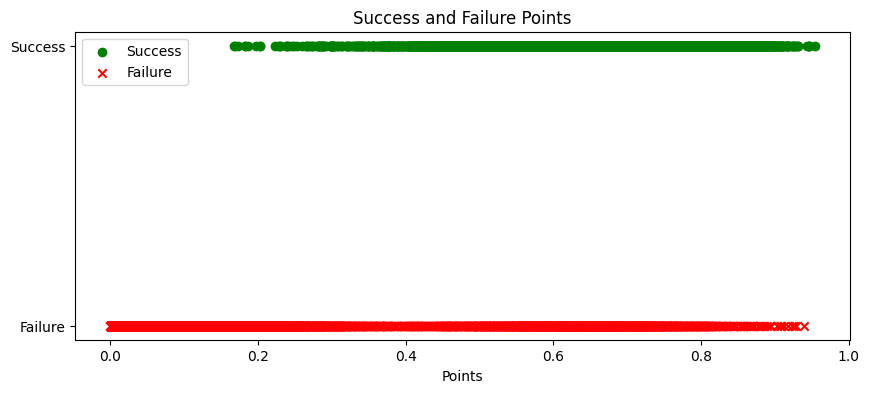

In [ ]:
# Plot scatter graph to show the scatter of the scores
# Create a figure and axis
plt.figure(figsize=(10, 4))

# Plot success points on a higher line (y=2)
plt.scatter(success, [2] * len(success), color='green', label='Success', marker='o')

# Plot failure points on a lower line (y=1)
plt.scatter(failure, [1] * len(failure), color='red', label='Failure', marker='x')

# Add labels and title
plt.title("Success and Failure Points")
plt.xlabel("Points")
plt.yticks([1, 2], ['Failure', 'Success'])  # Label the two lines
plt.legend()

# Display the plot
plt.show()

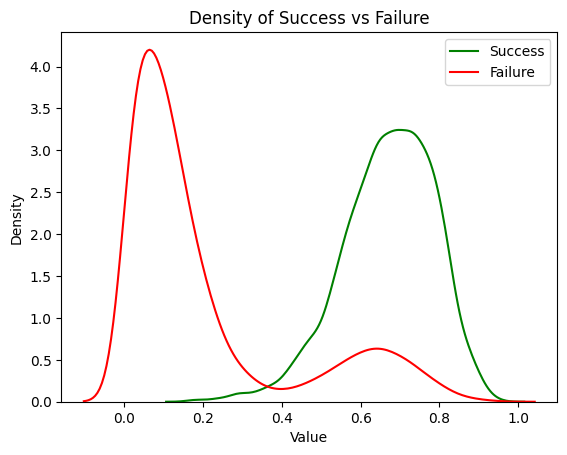

In [ ]:
# Create the KDE plot (no bars) for success data
sns.kdeplot(success, label='Success', color='green')

# Create the KDE plot (no bars) for failure data
sns.kdeplot(failure, label='Failure', color='red')

# Add labels and title
plt.title('Density of Success vs Failure')
plt.xlabel('Value')
plt.ylabel('Density')

# Add legend
plt.legend()

# Show plot
plt.show()

### Threshold

In [ ]:
# Calculate threshold using mean
threshold_mean = (np.mean(success) + np.mean(failure)) / 2
threshold_mean

0.4347255672892494

In [ ]:
# Calculate threshold using median
threshold_median = (np.median(success) + np.median(failure)) / 2
threshold_median

0.39663977921009064

In [ ]:
# Calculate threshold by testing 10000 different threshold and checking their accuracy score

# Combine scores and labels
all_scores = success + failure
labels = [1] * len(success) + [0] * len(failure)  # 1 for success, 0 for failure

# Find the best threshold
best_accuracy_threshold = None
best_accuracy = 0

for t in np.linspace(min(all_scores), max(all_scores), 10000):  # Test 10000 thresholds
    predictions = [1 if score > t else 0 for score in all_scores]
    accuracy = sum(p == l for p, l in zip(predictions, labels)) / len(labels)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_accuracy_threshold = t

print(f"Optimal Accuracy Threshold: {best_accuracy_threshold}")
print(f"Best Accuracy Score: {best_accuracy}")

Optimal Accuracy Threshold: 0.3656629267577032
Best Accuracy Score: 0.883148761274118


In [ ]:
# Combine scores and labels
all_scores = success + failure
labels = [1] * len(success) + [0] * len(failure)  # 1 for success, 0 for failure

# Initialize variables for the best threshold and combined score
best_threshold = None
best_f1 = 0

# Iterate over thresholds
for t in np.linspace(min(all_scores), max(all_scores), 10000):
    predictions = [1 if score > t else 0 for score in all_scores]

    # Calculate true positives, true negatives, false positives, and false negatives
    true_positives = sum(1 for p, l in zip(predictions, labels) if p == 1 and l == 1)
    true_negatives = sum(1 for p, l in zip(predictions, labels) if p == 0 and l == 0)
    false_positives = sum(1 for p, l in zip(predictions, labels) if p == 1 and l == 0)
    false_negatives = sum(1 for p, l in zip(predictions, labels) if p == 0 and l == 1)

    # Calculate precision
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0

    # Calculate precision
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    # Calculate F1
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    # Calculate accuracy
    accuracy = (true_positives + true_negatives) / len(labels)

    # Update the best threshold if the combined score is higher
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t
        best_accuracy = accuracy

print(f"Optimal Threshold: {best_threshold}")
print(f"Best Accuracy Score: {best_accuracy}")
print(f"Best F1 Score: {best_f1}")

Optimal Threshold: 0.3656629267577032
Best Precision Score: 0.7757945647167204
Best Accuracy Score: 0.883148761274118
Best Combined Score: 0.8681141679015528


In [ ]:
# Calculate threshold using roc curve

# Example scores and labels
all_scores = success + failure
labels = [1] * len(success) + [0] * len(failure)  # 1 for success, 0 for failure

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, all_scores)

# Find the threshold closest to (0, 1) in the ROC curve
optimal_idx = np.argmax(tpr - fpr)  # Maximize the true positive rate minus false positive rate
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold}")


Optimal Threshold: 0.3668292164802551


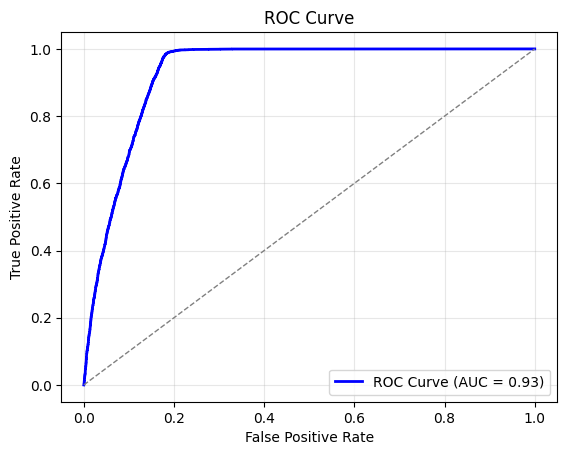

AUC: 0.93


In [ ]:
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"AUC: {roc_auc:.2f}")

In [ ]:
threshold = optimal_threshold

## Model With Threshold

In [ ]:
# Get doc and query and return the answer
def get_answer(doc,query,model):
  sentences = sent_tokenize(doc)
  scores = evaluate_sentences(sentences, model, query)
  best_score = max(scores, key=lambda x: x[1])

  answer = best_score[0]
  score = best_score[1]
  i = best_score[2]

  if score < threshold:
    return "Answer not found in context."

  return answer

## Model Comparsion

### Testing

In [ ]:
# Save miniLM model type for the testing function
miniLM_type = type(miniLM_model)

In [ ]:
# Test the model baset on the given dataset and return confusion matrix
def test_model(model, dataset):

  # Calculate the elapsed time
  start_t = time.time()

  tp = tn = fp = fn = 0

  for row in dataset:
    context = row["context"]
    question = row["question"]
    answer = row["answers"]["text"][0]
    answer_start = row["answers"]["answer_start"]

    # Check for model type, either miniLM or roBERTa
    if type(model) == miniLM_type:
      guess = get_answer(context,question,model)
    else:
      guess = answer_question(context,question, roberta_model)

    # Check answer, update confusion matrix based on the answer
    if guess == "Answer not found in context.":
      if answer == "":
        tn+=1
      else:
        fn+=1
    elif answer!="" and (answer in guess or guess in answer):
      tp+=1
    else:
      fp+=1

  end_t = time.time()

  elapsed_t = end_t - start_t
  print(f"Elapsed time: {elapsed_t} seconds")

  return [[tp, fp], [fn, tn]]

In [ ]:
# Get confusion matrix for roBERTa
roberta_results = test_model(roberta_model, dataset)

Elapsed time: 217.69685292243958 seconds


In [ ]:
# Get confusion matrix for miniLM
miniLM_results = test_model(miniLM_model, dataset)

Elapsed time: 305.3002927303314 seconds


### Results

In [ ]:
# Plot confusion matrix
def plot_confusion_matrix(matrix, models_name, labels=None):
    if labels is None:
        labels = ["Positive", "Negative"]

    fig, ax = plt.subplots(figsize=(6, 6))

    # Display the matrix
    ax.imshow(matrix, cmap="Blues")

    # Show the values in the matrix
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            ax.text(j, i, str(matrix[i][j]), ha="center", va="center", color="black")

    # Add labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    # Label axes
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title(f'Confusion Matrix For {models_name}')

    plt.tight_layout()
    plt.show()

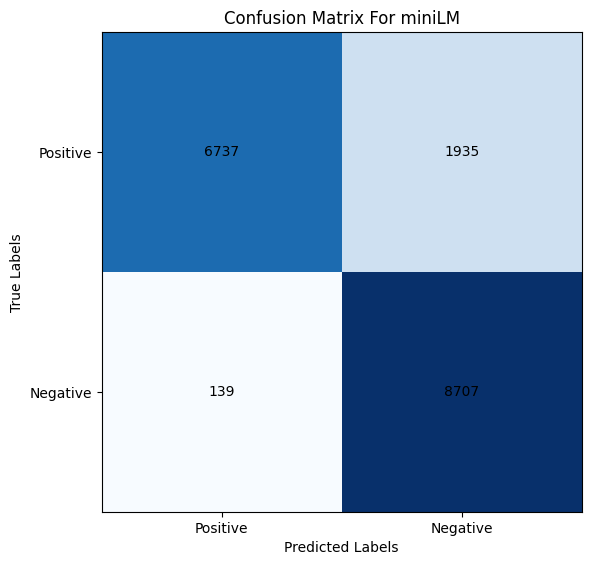

In [ ]:
plot_confusion_matrix(miniLM_results, "miniLM", labels=["Positive", "Negative"])

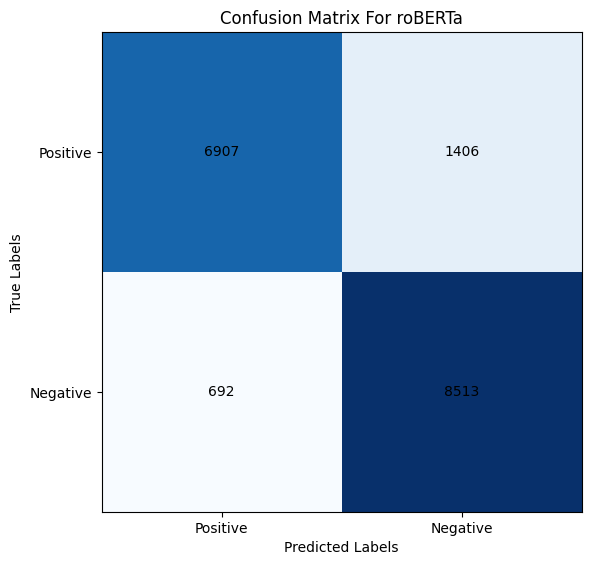

In [ ]:
plot_confusion_matrix(roberta_results, "roBERTa", labels=["Positive", "Negative"])

In [ ]:
# Calculate precision, recall, F1, accuracy scores
def scores(matrix):
  tp = matrix[0][0]
  fp = matrix[0][1]
  fn = matrix[1][0]
  tn = matrix[1][1]

  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1 = 2*precision*recall/(precision+recall)
  accuracy = (tp+tn)/(tp+tn+fp+fn)

  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")
  print(f"Accuracy: {accuracy}")

In [ ]:
scores(miniLM_results)

Precision: 0.7768680811808119
Recall: 0.9797847585805701
F1 Score: 0.8666066375096475
Accuracy: 0.8816074894394337


In [ ]:
scores(roberta_results)

Precision: 0.830867316251654
Recall: 0.9089353862350309
F1 Score: 0.8681498240321769
Accuracy: 0.8802374700308254


## Context Retrievel

In [ ]:
documents = list(df["initial_processed_text"])

In [ ]:
documents_embedded = torch.stack(list(df["embedded_miniLM_text"]), dim=0)

In [ ]:
# Return top documents based on miniLM and query
def retrieve_top_documents(embedded_query, documents_embedded, documents, top_k=5):

  # Compute cosine similarity scores
  cosine_scores_minilm = util.pytorch_cos_sim(embedded_query, documents_embedded)

  # Sort by similarity
  minilm_sorted_indices = np.argsort(-cosine_scores_minilm.numpy()[0])
  minilm_ranked_documents = [documents[i] for i in minilm_sorted_indices]

  return minilm_ranked_documents[:top_k]

In [ ]:
# Return top chunks based on miniLM and query
def retrieve_top_chunks(embedded_query, embedded_chunks, chunks, top_k=5):

    # Adjust top_k if it exceeds the number of chunks
    top_k = min(top_k, len(chunks))

    # Compute cosine similarities
    scores = util.cos_sim(embedded_query, embedded_chunks)[0]
    top_k_indices = torch.topk(scores, k=top_k).indices

    # Return the top-k most relevant chunks
    return [(chunks[i], scores[i].item()) for i in top_k_indices]


In [ ]:
# Return top chunk from all documents based on miniLM and query
# top_k = (docs, chunks, relevent_chunks)
def retrieve_relevent_chunks(query, documents_embedded, documents, retrievel_model, top_k=(5,5,5)):
  # Generate embeddings
  embedded_query = retrievel_model.encode(query, convert_to_tensor=True)

  # Retrieve top documents
  top_docs = retrieve_top_documents(embedded_query, documents_embedded, documents, top_k[0])

  # Retrieve top chunks for each document
  relevent_chunks = []
  for doc in top_docs:
    i = df[df["initial_processed_text"] == doc].index[0]
    chunks_embeddings = df["embedded_miniLM_chunks"][i]
    chunks = list(df["chunks_list"][i])
    top_chunks = retrieve_top_chunks(embedded_query, chunks_embeddings, chunks, top_k[1])
    relevent_chunks.extend(top_chunks)

  relevent_chunks = [chunk for chunk, _ in sorted(relevent_chunks, key=lambda x: x[1], reverse=True)][:top_k[2]]

  return relevent_chunks


## Final Models

### RoBERTa

In [ ]:
# Load the pre-trained fine-tuned RoBERTa model and tokenizer
model_name = "./fine_tuned_roberta_qa"
roberta_tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
roberta_model = RobertaForQuestionAnswering.from_pretrained(model_name)

In [ ]:
# Return best answer from documents based on roberta and query
def answer_question_roberta(relevant_chunks, query, model, tokenizer, retriever_model, batch_size=4, top_k=5):
    best_answer = None
    best_score = float('-inf')
    inputs_cache = None  # Cache for inputs corresponding to the best answer

    # Divide chunks into batches
    batches = [relevant_chunks[i:i + batch_size] for i in range(0, len(relevant_chunks), batch_size)]

    for batch in batches:
        # Prepare inputs for the batch
        batch_inputs = tokenizer(
            [query] * len(batch),  # Repeat the query for each chunk
            batch,
            return_tensors='pt', truncation=True, padding=True, max_length=256
        )

        # Forward pass through the QA model for the batch
        with torch.no_grad():
            outputs = model(**batch_inputs)

        # Extract logits
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

        for i, chunk in enumerate(batch):
            start_index = torch.argmax(start_logits[i]).item()
            end_index = torch.argmax(end_logits[i]).item()

            if start_index == 0:
              continue

            # Check for invalid answer length
            inputs_len = batch_inputs['input_ids'][i][start_index:end_index + 1].size()[0]
            if inputs_len < 2:
                continue

            # Calculate the confidence score
            confidence_score = start_logits[i, start_index].item() + end_logits[i, end_index].item()

            # Update the best answer if the confidence score is higher
            if confidence_score > best_score:
                best_score = confidence_score
                inputs_cache = batch_inputs
                best_answer_indices = (start_index, end_index)
                best_chunk_index = i  # Store the index of the best chunk

    if inputs_cache is None:
        return "Answer not found in context."

    # Decode the best answer
    start_index, end_index = best_answer_indices
    answer_tokens = inputs_cache['input_ids'][best_chunk_index][start_index:end_index + 1]  # +1 to include end index
    best_answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)

    return best_answer


### MiniLM

In [ ]:
# Evaluate all the sentences and return their scores
def retrieve_relevent_sentences(embedded_query, embedded_sentences, sentences, top_k=1):

  # Compute cosine similarities
  scores = util.cos_sim(embedded_query, embedded_sentences)[0]
  top_k_indices = torch.topk(scores, k=top_k).indices

  # Return the top-k most relevant chunks
  return [(sentences[i], scores[i].item()) for i in top_k_indices][0]

In [ ]:
# Return answer based on miniLM and query
def answer_question_miniLM(query, documents_embedded, documents, model):
    # Encode the query
    embedded_query = model.encode(query, convert_to_tensor=True)

    # Retrieve the top documents
    top_docs = retrieve_top_documents(embedded_query, documents_embedded, documents, top_k=5)

    # List to store top sentences
    relevent_sentences = []

    # Loop through the top documents to extract the most relevant sentences
    for doc in top_docs:
        # Find the index of the document in the dataframe
        i = df[df["initial_processed_text"] == doc].index[0]
        # Retrieve the embedded sentences and the list of sentences for the document
        embedded_sentences = df["embedded_miniLM_sentences"][i]
        sentences = list(df["sentences_list"][i])

        # Find the most relevant sentence
        best_sentence = retrieve_relevent_sentences(embedded_query, embedded_sentences, sentences, 1)

        # Extract the sentence and its similarity score
        answer = best_sentence[0]
        score = best_sentence[1]

        # If the similarity score is below the threshold, skip this sentence
        if score < threshold:
            continue
        else:
            # Add the relevant sentence to the list
            relevent_sentences.append(best_sentence)

    # If no relevant sentences are found, return no answer
    if not relevent_sentences:
        return "Answer not found in context."

    # Sort the relevant sentences by score and return the best answer
    return [answer for answer, _ in sorted(relevent_sentences, key=lambda x: x[1], reverse=True)][0]


# Answer Transformation

## Data Creation

In [ ]:
# Test the model baset on the given dataset and return df with data
def get_model_answers_df(model, dataset):

  context_list = []
  question_list = []
  answer_list = []
  guess_list = []
  scores = []

  # Calculate the elapsed time
  start_t = time.time()

  tp = tn = fp = fn = 0

  for row in dataset:
    context = row["context"]
    question = row["question"]
    answer = row["answers"]["text"][0]
    answer_start = row["answers"]["answer_start"]

    # Check for model type, either miniLM or roBERTa
    if type(model) == miniLM_type:
      guess = get_answer(context,question,model)
    else:
      guess = answer_question(context,question, roberta_model)

    # Check answer, update confusion matrix based on the answer
    if guess == "Answer not found in context.":
      if answer == "":
        scores.append("tn")
      else:
        scores.append("fn")
    elif answer!="" and (answer in guess or guess in answer):
      scores.append("tp")
    else:
      scores.append("fp")

    context_list.append(context)
    question_list.append(question)
    answer_list.append(answer)
    guess_list.append(guess)

  end_t = time.time()

  elapsed_t = end_t - start_t
  print(f"Elapsed time: {elapsed_t} seconds")

  return pd.DataFrame({"context": context_list, "question": question_list, "answer": answer_list, "guess": guess_list, "score": scores})

In [ ]:
df_miniLM = get_model_answers_df(miniLM_model, dataset)
df_roberta = get_model_answers_df(roberta_model, dataset)

df_miniLM_experiment = df_miniLM.loc[df_miniLM['guess'] != 'Answer not found in context.'][:20].reset_index(drop = True)
df_roberta_experiment = df_roberta.loc[df_roberta['guess'] != 'Answer not found in context.'][:20].reset_index(drop = True)

Elapsed time: 451.5097961425781 seconds
Elapsed time: 340.79610681533813 seconds


## Model Building & Testing

In [ ]:
# Load model and tokenizer
model_name = "tuner007/pegasus_paraphrase"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


full answer: what is the capital of France


In [ ]:
# Define different sentence structures
sentence_structures = [
    ("Q&A", lambda q, g: f"Question: {q[:-1]}. Answer: {g}"),  # Format with question and answer explicitly labeled
    ("Comma", lambda q, g: f"{q[:-1]}, {g}"),                  # Simple concatenation
    ("Formal", lambda q, g: f"The answer to '{q[:-1]}' is {g}"),  # Formal statement
    ("Answer First", lambda q, g: f"{g} is the answer to the question: {q[:-1]}."),  # Answer first with statement
    ("Answer First Simple", lambda q, g: f"{g} {q}"),          # Answer first
    ("Question First Simple", lambda q, g: f"{q}{g}"),         # Question first
    ("Answer Only", lambda q, g: f"{g}")                       # Answer only
]

# Generate paraphrase for each structure
def generate_paraphrases(row):
    results = []
    for structure_name, structure_fn in sentence_structures:
        try:
            # Create input sentence using the current structure
            sentence = structure_fn(row['question'], row['guess'])

            # Tokenize input with truncation
            input_ids = tokenizer.encode(
                sentence,
                return_tensors="pt",
                truncation=True,
            )

            # Generate paraphrased text
            paraphrase_ids = model.generate(
                input_ids,
                num_beams=3,
                max_length=100,
                early_stopping=True
            )

            # Decode the output
            paraphrase = tokenizer.decode(paraphrase_ids[0], skip_special_tokens=True)
            results.append((structure_name, sentence, paraphrase))
        except Exception as e:
            results.append((structure_name, sentence, f"[Error: {e}]"))
    return results


In [ ]:
def results_into_df(df):
  # Generate paraphrases for all rows and expand the DataFrame
  expanded_rows = []
  for _, row in df.iterrows():
      paraphrases = generate_paraphrases(row)
      for structure_name, input_sentence, paraphrase in paraphrases:
          expanded_rows.append({
              "question": row["question"],
              "guess": row["guess"],
              "structure_name": structure_name,
              "input_sentence": input_sentence,
              "paraphrase": paraphrase
          })

  # Update DataFrame with the expanded rows
  df = pd.DataFrame(expanded_rows)

  # Sort by sentence structure
  df = df.sort_values(by="structure_name")

  return df

In [ ]:
# Save the resulting DataFrame to a CSV file
output_path_roberta = "paraphrased_expanded_roberta.csv"
results_into_df(df_roberta_experiment).to_csv(output_path_roberta, index=False)

output_path_minilm = "paraphrased_expanded_miniLM.csv"
results_into_df(df_miniLM_expanded).to_csv(output_path_minilm, index=False)

## Final Model

In [ ]:
# Return transformed answer using answer and query
def transform_answer(answer, query, model, tokenizer):
  # Create input sentence using the current structure
  sentence = f"Question: {query}. Answer: {answer}"

  # Tokenize input with truncation
  input_ids = tokenizer_pegasus.encode(
    sentence,
    return_tensors="pt",
    truncation=True,
  )

  # Generate paraphrased text
  paraphrase_ids = model_pegasus.generate(
    input_ids,
    num_beams=10,
    max_length=60,
    early_stopping=True
  )

  # Decode the output
  paraphrase = tokenizer_pegasus.decode(paraphrase_ids[0], skip_special_tokens=True)

  # Check if model return unwanted "Answer: ", if yes, removes it
  if paraphrase.startswith("Answer: "):
    paraphrase = paraphrase[len("Answer: "):]

  return paraphrase

# Final UI

In [ ]:
# Define the widgets
corrected_toggle = widgets.ToggleButtons(
    options=["Corrected", "Uncorrected"],
    description="Query:",
    value="Corrected"
)
model_selector = widgets.ToggleButtons(
    options=["MiniLM", "RoBERTa"],
    description="Model:",
    value="MiniLM"
)
paraphrase_toggle = widgets.ToggleButtons(
    options=["Paraphrased", "Original"],
    description="Answer:",
    value="Paraphrased"
)

In [ ]:
# Define the callback function
def on_run_button_click(b):
    with output_area:
        clear_output(wait=True)  # Clear output area before printing
        query = query_input.value
        use_corrected = corrected_toggle.value == "Corrected"
        use_minilm = model_selector.value == "MiniLM"
        use_paraphrased = paraphrase_toggle.value == "Paraphrased"

        # Display a loading animation like a spinning circle
        loading_html = """
        <div style='display: flex; align-items: center; justify-content: center; height: 100px;'>
            <div class="spinner"></div>
        </div>
        <style>
            .spinner {
                border: 5px solid rgba(0,0,0,0.1);
                border-radius: 50%;
                border-top: 5px solid #3498db;
                width: 30px;
                height: 30px;
                animation: spin 1s linear infinite;
            }
            @keyframes spin {
                0% { transform: rotate(0deg); }
                100% { transform: rotate(360deg); }
            }
        </style>
        """
        display(HTML(loading_html))

        # Clear the answer variable
        answer = None

        if use_corrected:
            beam_width = 3
            query = " ".join(correct_spelling_error(query, vocab, beam_width, trigram_counts, bigram_counts, unigram_counts)[1])

        relevant_chunks = retrieve_relevent_chunks(query, documents_embedded, documents, miniLM_model, (10,10,4))

        if use_minilm:
            answer = answer_question_miniLM(query, documents_embedded, documents, miniLM_model)
        else:
            answer = answer_question_roberta(relevant_chunks, query, roberta_model, roberta_tokenizer, miniLM_model, batch_size=8)

        if use_paraphrased:
            answer = transform_answer(answer, query, model_pegasus, tokenizer_pegasus)

        # If there's an answer, remove the loading spinner
        if answer:
            clear_output(wait=True)

        # Display results in a formatted way
        display(HTML(f"<div style='border: 1px solid #ccc; padding: 5px; margin-top: 10px; border-radius: 5px; background-color: #f9f9f9; width: 50%;'>"
                     f"<p style='color: #333;'>{answer}</p>"
                     f"</div>"))

In [ ]:
# Define widgets
run_button = widgets.Button(description="Run", button_style='success')
output_area = widgets.Output()
query_input = widgets.Text(description="Query:")

# Display the widgets
display(query_input, corrected_toggle, model_selector, paraphrase_toggle, run_button, output_area)

# Attach the callback to the button
run_button.on_click(on_run_button_click)

Text(value='', description='Query:')

ToggleButtons(description='Query:', options=('Corrected', 'Uncorrected'), value='Corrected')

ToggleButtons(description='Model:', index=1, options=('MiniLM', 'RoBERTa'), value='RoBERTa')

ToggleButtons(description='Answer:', index=1, options=('Paraphrased', 'Original'), value='Original')

Button(button_style='success', description='Run', style=ButtonStyle())

Output()